# Hessian Approximation for Toy Models

The idea behind this notebook is to compare the implementations of the various approximations and keep track of all of the results.

In the first part, several sanity checks are performed, which serve to provide a better understanding of the relationships and to ensure the correctness of the code.

The second part then delves deeper into the context and presents different results.

In [114]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
# === Core Python ===
from typing import Any

# === Math / Plotting ===
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random

# === Sklearn ===
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# === Project Imports ===
from config.config import (
    Config,
    ModelConfig,
    RandomRegressionConfig,
    TrainingConfig,
    LinearModelConfig,
    UCIDatasetConfig,
    RandomClassificationConfig,
    KFACConfig,
    CIFAR10DatasetConfig,
    MNISTDatasetConfig,
    MLPModelConfig,
    get_config,
)
from main import train
from data.data import AbstractDataset
from models.train import ApproximationModel, get_loss_fn
from hessian_approximations.factory import (
    create_hessian_by_name,
    hessian_approximation,
)
from hessian_approximations.hessian.hessian import Hessian
from hessian_approximations.kfac.kfac import KFAC
from metrics.metrics import METRICS, compare_matrices


## Sanity Checks

### 1. Linear Regression with 1-D Output for Random Dataset
**Main goal**: Comparing the sklearn regression setup with the JAX Setup

In [116]:
from config.config import (
    Config,
    ModelConfig,
    RandomRegressionConfig,
    TrainingConfig,
    TrainingConfig,
    get_config,
)
from main import train


# config = get_config("random_regression_single_feature")
config = Config(
    dataset=RandomRegressionConfig(
        n_samples=1000,
        n_features=1,
        n_targets=1,
        noise=10,
        random_state=42,
        train_test_split=1,
    ),
    model=ModelConfig(name="linear", loss="mse"),
    training=TrainingConfig(
        epochs=100,
        lr=0.01,
        optimizer="sgd",
        batch_size=100,
        loss="mse",
    ),
)
model, dataset, params = train(config)

100%|██████████| 100/100 [00:00<00:00, 135.70it/s]


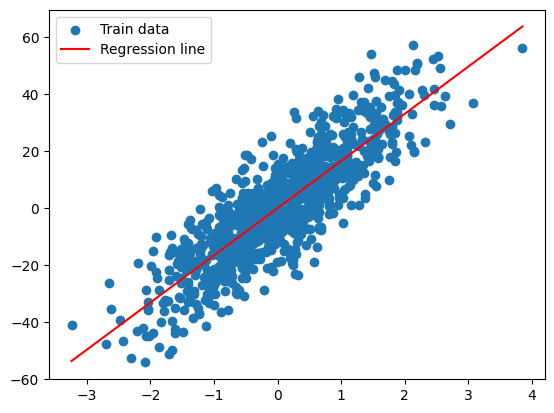

In [117]:
## Plot results
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import random

x, y = dataset.get_train_data()
x_test = jnp.linspace(jnp.min(x), jnp.max(x), 100).reshape(-1, 1)
y_pred = model.apply(params, x_test)
plt.scatter(x, y, label="Train data")

# make regression line red
plt.plot(x_test, y_pred, color="red", label="Regression line")
plt.legend()
plt.show()


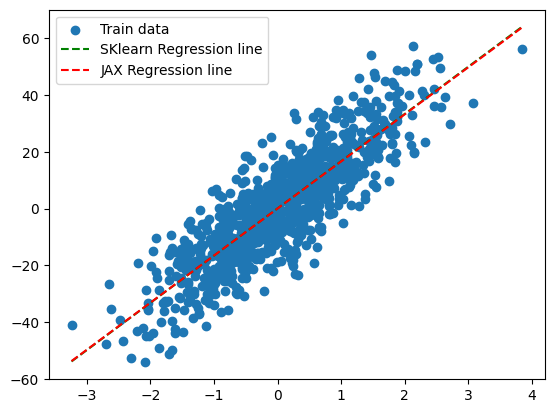

MSE between JAX and SKlearn predictions: 0.017557382583618164


In [118]:
### Compare with sklearn

from sklearn.linear_model import LinearRegression

sk_model = LinearRegression()
sk_model.fit(np.array(x), np.array(y))
y_sk_pred = sk_model.predict(np.array(x_test))
plt.scatter(x, y, label="Train data")
plt.plot(
    x_test, y_sk_pred, color="green", linestyle="--", label="SKlearn Regression line"
)
plt.plot(x_test, y_pred, color="red", linestyle="--", label="JAX Regression line")
plt.legend()
plt.show()

## Calculate MSE for both models
# The MSE should be very small, close to 0
from sklearn.metrics import mean_squared_error

mse_jax = mean_squared_error(np.array(y_pred), np.array(y_sk_pred))
print(f"MSE between JAX and SKlearn predictions: {mse_jax}")


### 2. Linear Regression on Energy Dataset

**Main goal:** Verify correctness of implementation by comparing the trained regression setting with (exact) sklearn regression implementation, then moving on to the hessian.

For the hessian, we first introduce some notation:
- $H = $ Hessian of a model which is generated by double differentiation using JAX $\texttt{hessian}$ function
- $H_{\text{exact}} = $ Hessian which is computed by some exact formula (only applicable for linear model setting, i.e., linear regression, linear classification)
- $H_{\text{GNH}} = $ Gauss-Newton Hessian ($J^T_{\theta} H_{\text{output}} J_{\theta}$) computed by using JAX differentiation tools

For the Hessian in the regression setting it yields: 
$$ H = H_{GNH} $$

So in the linear setting want to observe that 
$$ || H_{\text{exact}} - H_{GNH} || \approx || H_{\text{exact}} - H || \approx 0 $$

Furthermore, we are interested in the connection of the Fisher information matrix $ F(\theta \mid X)$ to the Hessian. Based on calculus it should hold:
$$ F(\theta \mid X) = \frac{1}{\sigma^2} X^\top X = \frac{\sigma^2}{2} H$$

In [119]:
from config.config import LinearModelConfig, UCIDatasetConfig, get_config
from main import train


# config = get_config("energy")
config = Config(
    dataset=UCIDatasetConfig(
        name="energy",
        train_test_split=1,
    ),
    model=LinearModelConfig(name="linear", loss="mse", hidden_dim=[]),
    training=TrainingConfig(
        epochs=200,
        lr=0.01,
        batch_size=768,
        optimizer="adam",
        loss="mse",
    ),
)
model_2, dataset_2, params_2 = train(config)

100%|██████████| 200/200 [00:01<00:00, 179.03it/s]


In [120]:
## Compare with sklearn
x, y = dataset_2.get_train_data()
y_pred = model_2.apply(params_2, x)

from sklearn.linear_model import LinearRegression

sk_model = LinearRegression()
sk_model.fit(np.array(x), np.array(y))
sk_predictions = sk_model.predict(np.array(x))

## Calculate MSE for both models
# Distance should be very small
from sklearn.metrics import mean_squared_error

mse_jax = mean_squared_error(np.array(y_pred), np.array(sk_predictions))
print(f"MSE between JAX and SKlearn predictions: {mse_jax}")


MSE between JAX and SKlearn predictions: 0.00020859284268226475


#### Hessian Comparison

In [121]:
# config = get_config("energy")
config_2 = Config(
    dataset=UCIDatasetConfig(
        name="energy",
        train_test_split=1,
    ),
    model=LinearModelConfig(name="linear", loss="mse", hidden_dim=[]),
    training=TrainingConfig(
        epochs=200,
        lr=0.01,
        batch_size=768,
        optimizer="adam",
        loss="mse",
    ),
)
model_2, dataset_2, params_2 = train(config_2)

config_3 = Config(
    dataset=RandomRegressionConfig(
        n_samples=1000,
        n_features=100,
        n_targets=10,
        noise=20,
        random_state=42,
        train_test_split=1,
    ),
    model=LinearModelConfig(loss="mse", hidden_dim=[]),
    training=TrainingConfig(
        epochs=200,
        lr=0.001,
        batch_size=100,
        optimizer="sgd",
        loss="mse",
    ),
)
model_3, dataset_3, params_3 = train(config_3)

100%|██████████| 200/200 [00:01<00:00, 140.16it/s]


In [122]:
from typing import Any
from data.data import AbstractDataset
from hessian_approximations.factory import (
    create_hessian_by_name,
    hessian_approximation,
)
from models.train import ApproximationModel, get_loss_fn


def compare_hessians(
    model: ApproximationModel, params: Any, dataset: AbstractDataset, config: Config
):
    exact_hessian_regression = {
        "name": "exact-hessian-regression",
        "create": create_hessian_by_name("exact-hessian-regression"),
    }
    hessian = {"name": "hessian", "create": create_hessian_by_name("hessian")}
    gauss_newton = {
        "name": "gauss-newton",
        "create": create_hessian_by_name("gauss-newton"),
    }

    hessian_approximations = [exact_hessian_regression, hessian, gauss_newton]
    hessian_results = {}

    for hessian_approx in hessian_approximations:
        hessian_matrix = hessian_approximation(
            method=hessian_approx["create"],
            model=model,
            parameters=params,
            test_data=jnp.asarray(dataset.get_train_data()[0]),
            test_targets=jnp.asarray(dataset.get_train_data()[1]),
            loss=get_loss_fn(config.model.loss),
        )

        hessian_results[hessian_approx["name"]] = hessian_matrix

    # Compare the Hessian matrices
    for i in range(len(hessian_results)):
        for j in range(i + 1, len(hessian_results)):
            i_name = hessian_approximations[i]["name"]
            j_name = hessian_approximations[j]["name"]
            i_matrix = hessian_results[i_name]
            j_matrix = hessian_results[j_name]
            matrix_diff = i_matrix - j_matrix
            diff = jnp.linalg.norm(matrix_diff, "fro")
            print(
                f"Difference between {i_name} and {j_name} for Frobenius norm: {diff}"
            )

    print("----")
    # Search for max different entries
    for i in range(len(hessian_results)):
        for j in range(i + 1, len(hessian_results)):
            i_name = hessian_approximations[i]["name"]
            j_name = hessian_approximations[j]["name"]
            matrix_diff = hessian_results[i_name] - hessian_results[j_name]

            max_diff = jnp.max(jnp.abs(matrix_diff))
            print(f"Max absolute difference between {i_name} and {j_name}: {max_diff}")


print("Results for Energy dataset:")
compare_hessians(model_2, params_2, dataset_2, config_2)
print("======")
print("Results for Random Regression dataset:")
compare_hessians(model_3, params_3, dataset_3, config_3)

Results for Energy dataset:
Difference between exact-hessian-regression and hessian for Frobenius norm: 7.288075644954694e-06
Difference between exact-hessian-regression and gauss-newton for Frobenius norm: 4.891482708761623e-06
Difference between hessian and gauss-newton for Frobenius norm: 5.463207799039083e-06
----
Max absolute difference between exact-hessian-regression and hessian: 2.5033950805664062e-06
Max absolute difference between exact-hessian-regression and gauss-newton: 2.086162567138672e-06
Max absolute difference between hessian and gauss-newton: 2.0265579223632812e-06
Results for Random Regression dataset:
Difference between exact-hessian-regression and hessian for Frobenius norm: 2.36254007649297e-06
Difference between exact-hessian-regression and gauss-newton for Frobenius norm: 2.5062224105531273e-06
Difference between hessian and gauss-newton for Frobenius norm: 2.3904292447696207e-06
----
Max absolute difference between exact-hessian-regression and hessian: 4.76837

#### FIM vs. Hessian

Note, that this comparison calculates the empirical FIM to be able to compare the true Hessian with the FIM implementation. The equality holds for the 'true' FIM only when the loss of the trained model is minimized.

Remember, when setting $\sigma^2 = 1$, we want to observe:
$$ F(\theta \mid X) = \frac{1}{2} H$$

In [123]:
hessian = {"name": "hessian", "create": create_hessian_by_name("hessian")}
fim = {"name": "fim", "create": create_hessian_by_name("fim")}

hessian_approximations = [hessian, fim]
hessian_results = {}

for hessian_approx in hessian_approximations:
    hessian_matrix = hessian_approximation(
        method=hessian_approx["create"],
        model=model_3,
        parameters=params_3,
        test_data=jnp.asarray(dataset_3.get_train_data()[0]),
        test_targets=jnp.asarray(dataset_3.get_train_data()[1]),
        loss=get_loss_fn(config_3.model.loss),
    )

    hessian_results[hessian_approx["name"]] = hessian_matrix

# Compare the Hessian matrices
hessian_matrix = hessian_results["hessian"]
fim_matrix = hessian_results["fim"]

# Check, that FIM is approximately half of the Hessian for regression with MSE loss
matrix_diff = hessian_matrix - 2 * fim_matrix
diff = jnp.linalg.norm(matrix_diff, "fro")
print(f"Difference between hessian and fim for Frobenius norm: {diff}")


Difference between hessian and fim for Frobenius norm: 2.5554636522429064e-06


### 3. E-KFAC

First we want to verify that our implementation is correct. We're doing that by comparing the computed covariances with the gradient of the logits of each layer. We define  
$$ 
s_l = \nabla_{W_l a_{l-1}} \log p(y \mid x; \theta) 
$$  
as the preactivation gradients of a single layer and  
$$ 
a_l = \phi(W_l a_{l-1}) 
$$  
as the activations of layer $l$.

Then KFAC approximates the Gauss-Newton Hessian by a block-diagonal structure, leaving every block $\mathbb{G}_l$ independent, and each $\mathbb{G}_l$ is defined as:
$$
\mathbb{G}_l \approx \mathbb{E}[a_{l-1} a_{l-1}^T] \otimes \mathbb{E}[s_l s_l^T]
$$

Based on the derivation of KFAC it should hold:
$$
\begin{align}
\nabla_{W_l} \log p(y \mid x; \theta)
&= \nabla_{W_l a_{l-1}} \log p(y \mid x; \theta) \, a_{l-1}^\top \\
&= s_l \, a_{l-1}^\top
\end{align}
$$

That's what we want to verify first!


In [124]:
from config.config import RandomClassificationConfig


config_ekfac = Config(
    dataset=RandomClassificationConfig(
        n_samples=1000,
        n_features=20,
        n_informative=10,
        n_classes=3,
        random_state=42,
        train_test_split=1,
    ),
    model=LinearModelConfig(name="linear", loss="cross_entropy", hidden_dim=[10, 5]),
    training=TrainingConfig(
        epochs=100,
        lr=0.001,
        optimizer="sgd",
        loss="cross_entropy",
    ),
)

model_ekfac, dataset_ekfac, params_ekfac = train(config_ekfac)

100%|██████████| 100/100 [00:00<00:00, 119.17it/s]


In [125]:
from config.config import KFACConfig
from hessian_approximations.kfac.kfac import KFAC

# Create KFAC object and generate components
kfac_config = KFACConfig(use_eigenvalue_correction=True)
kfac_approx = KFAC(config=kfac_config)
kfac_approx.config.use_eigenvalue_correction = True
training_data, training_targets = dataset_ekfac.get_train_data()
training_data = jnp.asarray(training_data)
training_targets = jnp.asarray(training_targets)

kfac_approx.generate_ekfac_components(
    model=model_ekfac,
    params=params_ekfac,
    training_data=training_data,
    training_targets=training_targets,
    loss_fn=get_loss_fn(config_ekfac.model.loss),
)


Computing EKFAC components from scratch.


In [126]:
import jax


def normal_loss_fn(params, x, y, model):
    """Standard loss function without KFAC wrapper."""
    pred = model.apply(params, x)
    return get_loss_fn(config_ekfac.model.loss)(pred, y, reduction="sum")


ground_truth_grads = jax.grad(normal_loss_fn)(
    params_ekfac, training_data, training_targets, model_ekfac
)

for key in ground_truth_grads["params"].keys():
    true_grad = ground_truth_grads["params"][key]["kernel"]

    a = kfac_approx.collector.captured_data[key][0]
    g = kfac_approx.collector.captured_data[key][1]

    ag = jnp.einsum("ni,nj->ij", a, g)

    # Find max absolute difference
    max_diff = jnp.max(jnp.abs(ag - true_grad))
    print(f"Max absolute difference for {key}: {max_diff}")

    # Find Frobenius norm of the difference
    frob_diff = jnp.linalg.norm(ag - true_grad, "fro")
    print(f"Frobenius norm of difference for {key}: {frob_diff}")


Max absolute difference for linear_0: 3.814697265625e-06
Frobenius norm of difference for linear_0: 6.594332262466196e-06
Max absolute difference for linear_1: 7.62939453125e-06
Frobenius norm of difference for linear_1: 9.22852359508397e-06
Max absolute difference for output: 1.52587890625e-05
Frobenius norm of difference for output: 3.4295830118935555e-05


## Analysis

### Quick Comparison of Hessian vs. KFAC vs. EKFAC

In [127]:
from hessian_approximations.hessian.hessian import Hessian


config_comparison_linear = Config(
    dataset=RandomClassificationConfig(
        n_samples=10000,
        n_features=20,
        n_informative=4,
        n_classes=3,
        random_state=42,
        train_test_split=1,
    ),
    model=LinearModelConfig(loss="cross_entropy", hidden_dim=[]),
    training=TrainingConfig(
        epochs=200,
        batch_size=500,
        lr=0.001,
        optimizer="sgd",
        loss="cross_entropy",
    ),
)
model_comparison_linear, dataset_comparison_linear, params_comparison_linear = train(
    config_comparison_linear
)


kfac_config = KFACConfig(use_eigenvalue_correction=False, use_pseudo_targets=True)
kfac_approx = KFAC(config=kfac_config)

ekfac_config = KFACConfig(use_eigenvalue_correction=True, use_pseudo_targets=True)
ekfac_approx = KFAC(config=ekfac_config)

hessian = Hessian()

# Compute hessian for all 3 methods
h_kfac = kfac_approx.compute_hessian(
    model=model_comparison_linear,
    params=params_comparison_linear,
    training_data=jnp.asarray(dataset_comparison_linear.get_train_data()[0]),
    training_targets=jnp.asarray(dataset_comparison_linear.get_train_data()[1]),
    loss_fn=get_loss_fn(config_comparison_linear.model.loss),
)

h_ekfac = ekfac_approx.compute_hessian(
    model=model_comparison_linear,
    params=params_comparison_linear,
    training_data=jnp.asarray(dataset_comparison_linear.get_train_data()[0]),
    training_targets=jnp.asarray(dataset_comparison_linear.get_train_data()[1]),
    loss_fn=get_loss_fn(config_comparison_linear.model.loss),
)

h_true = hessian.compute_hessian(
    model=model_comparison_linear,
    params=params_comparison_linear,
    training_data=jnp.asarray(dataset_comparison_linear.get_train_data()[0]),
    training_targets=jnp.asarray(dataset_comparison_linear.get_train_data()[1]),
    loss_fn=get_loss_fn(config_comparison_linear.model.loss),
)

# Compute eigenvalues for all 3 methods
eigenvalues_kfac = jnp.linalg.eigvalsh(h_kfac)
eigenvalues_ekfac = jnp.linalg.eigvalsh(h_ekfac)
eigenvalues_true = jnp.linalg.eigvalsh(h_true)


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:12<00:00, 16.23it/s]


Computing EKFAC components from scratch.
Computing EKFAC components from scratch.


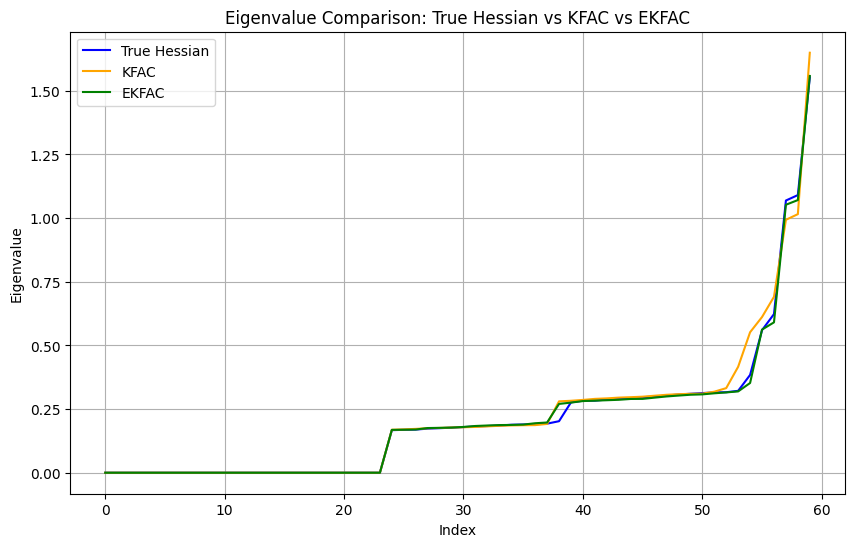

In [128]:
# Plot the eigenvalues
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(eigenvalues_true, label="True Hessian", color="blue")
plt.plot(eigenvalues_kfac, label="KFAC", color="orange")
plt.plot(eigenvalues_ekfac, label="EKFAC", color="green")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalue Comparison: True Hessian vs KFAC vs EKFAC")
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 200/200 [00:12<00:00, 16.09it/s]


Computing EKFAC components from scratch.
Computing EKFAC components from scratch.


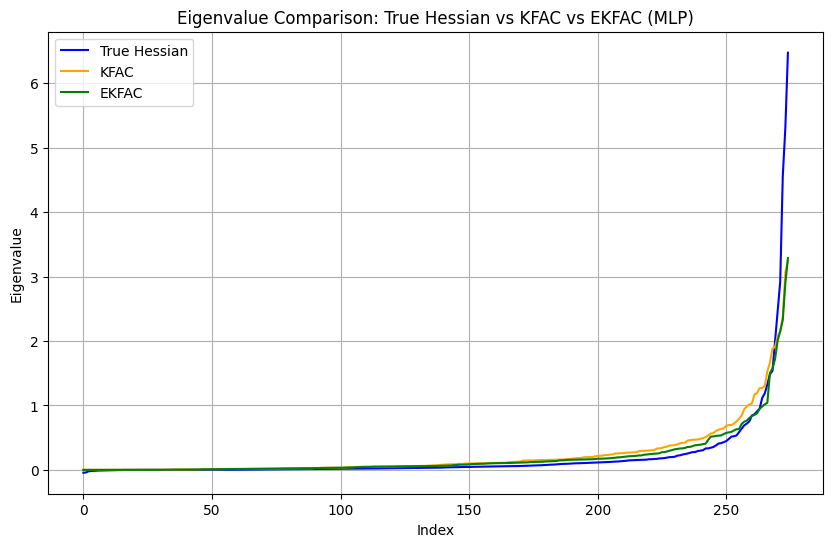

In [129]:
from config.config import MLPModelConfig


config_comparison_mlp = Config(
    dataset=RandomClassificationConfig(
        n_samples=10000,
        n_features=20,
        n_classes=5,
        random_state=42,
        train_test_split=1,
    ),
    model=MLPModelConfig(loss="cross_entropy", hidden_dim=[10, 5]),
    training=TrainingConfig(
        epochs=200,
        batch_size=500,
        lr=0.001,
        optimizer="sgd",
        loss="cross_entropy",
    ),
)

model_comparison_mlp, dataset_comparison_mlp, params_comparison_mlp = train(
    config_comparison_mlp
)

kfac_config = KFACConfig(use_eigenvalue_correction=False, use_pseudo_targets=True)
kfac_approx = KFAC(config=kfac_config)

ekfac_config = KFACConfig(use_eigenvalue_correction=True, use_pseudo_targets=True)
ekfac_approx = KFAC(config=ekfac_config)

hessian = Hessian()
# Compute hessian for all 3 methods
h_kfac = kfac_approx.compute_hessian(
    model=model_comparison_mlp,
    params=params_comparison_mlp,
    training_data=jnp.asarray(dataset_comparison_mlp.get_train_data()[0]),
    training_targets=jnp.asarray(dataset_comparison_mlp.get_train_data()[1]),
    loss_fn=get_loss_fn(config_comparison_mlp.model.loss),
)


h_ekfac = ekfac_approx.compute_hessian(
    model=model_comparison_mlp,
    params=params_comparison_mlp,
    training_data=jnp.asarray(dataset_comparison_mlp.get_train_data()[0]),
    training_targets=jnp.asarray(dataset_comparison_mlp.get_train_data()[1]),
    loss_fn=get_loss_fn(config_comparison_mlp.model.loss),
)

h_true = hessian.compute_hessian(
    model=model_comparison_mlp,
    params=params_comparison_mlp,
    training_data=jnp.asarray(dataset_comparison_mlp.get_train_data()[0]),
    training_targets=jnp.asarray(dataset_comparison_mlp.get_train_data()[1]),
    loss_fn=get_loss_fn(config_comparison_mlp.model.loss),
)


# Compute eigenvalues for all 3 methods
eigenvalues_kfac = jnp.linalg.eigvalsh(h_kfac)
eigenvalues_ekfac = jnp.linalg.eigvalsh(h_ekfac)
eigenvalues_true = jnp.linalg.eigvalsh(h_true)


# Plot the eigenvalues
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(eigenvalues_true, label="True Hessian", color="blue")
plt.plot(eigenvalues_kfac, label="KFAC", color="orange")
plt.plot(eigenvalues_ekfac, label="EKFAC", color="green")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalue Comparison: True Hessian vs KFAC vs EKFAC (MLP)")
plt.legend()
plt.grid(True)
plt.show()

###  Comparing Full Hessians

We want to check how well EKFAC approximates the full Hessian / Gauss-Newton-Hessian for different models: So we split up the analysis in the following categories:
- Model size
- Model complexity

More concretely:
1. Linear Model with Single Linear Layer
2. Deep Linear Model with Multiple Linear Layers
3. MLP with Single Layer
4. MLP with Multiple Layers

We want diversify also on the different models which we use, so we consider the following models for classification:
1. Random Classification
2. MNIST
3. CIFAR10

#### Linear Model with Single Linear Layer

In [130]:
%autoreload 2

In [131]:
# 10 balanced target total parameter sizes (≤ 5k)
n_samples = 2000
random_state = 42

# --- Gradual scaling from simple to complex ---
# total parameter size increases smoothly up to ~5k
target_param_sizes = np.linspace(20, 5000, num=10, dtype=int).tolist()
n_classes_list = [2, 3, 4, 5, 8, 10, 15, 20, 30, 40]

dataset_nums = []

for i, (target_params, n_classes) in enumerate(zip(target_param_sizes, n_classes_list)):
    # derive n_features
    n_features = max(10, int(target_params / n_classes))

    # scale informative features proportionally to n_features (min 2, max 100)
    n_informative = min(max(2, int(0.6 * n_features)), 100)

    dataset_nums.append(
        {
            "n_samples": n_samples,
            "n_features": n_features,
            "n_classes": n_classes,
            "n_informative": n_informative,
            "total_params": n_features * n_classes,
        }
    )


dataset_configs = {}
training_configs = {}

for dataset_num in dataset_nums:
    n_samples = dataset_num["n_samples"]
    n_features = dataset_num["n_features"]
    n_classes = dataset_num["n_classes"]
    n_informative = dataset_num["n_informative"]
    dataset_configs[f"random_classification_{n_samples}_{n_features}_{n_classes}"] = (
        RandomClassificationConfig(
            n_samples=n_samples,
            n_features=n_features,
            n_classes=n_classes,
            n_informative=n_informative,
            random_state=42,
            train_test_split=1,
        )
    )
    training_configs[f"random_classification_{n_samples}_{n_features}_{n_classes}"] = (
        TrainingConfig(
            epochs=100,
            lr=0.001,
            optimizer="sgd",
            batch_size=100,
            loss="cross_entropy",
        )
    )


In [132]:
from typing import Dict

from hessian_approximations.hessian_approximations import HessianApproximation


def compare_approximation_with_true_hessian(
    model: ApproximationModel,
    params: Any,
    dataset: AbstractDataset,
    hessian_configs_approx: Dict[str, HessianApproximation],
    hessian_config_gt: HessianApproximation,
):
    results_dict = {}

    print("Computing true Hessian...")
    true_hessian = hessian_approximation(
        method=hessian_config_gt,
        model=model,
        parameters=params,
        test_data=jnp.asarray(dataset.get_train_data()[0]),
        test_targets=jnp.asarray(dataset.get_train_data()[1]),
        loss=get_loss_fn("cross_entropy"),
    )
    print("Comparing approximations...")
    for approx_name, approx_method in hessian_configs_approx.items():
        print(f"Computing {approx_name}...")
        approximation_matrix = hessian_approximation(
            method=approx_method,
            model=model,
            parameters=params,
            test_data=jnp.asarray(dataset.get_train_data()[0]),
            test_targets=jnp.asarray(dataset.get_train_data()[1]),
            loss=get_loss_fn("cross_entropy"),
        )

        results_dict[approx_name] = compare_matrices(
            matrix_gt=true_hessian,
            matrix_approx=approximation_matrix,
            metrics=METRICS["all_matrix"],
        )
    return results_dict

In [133]:
# Linear Model Single Layer
results_dict = {}

for dataset_name, dataset_config in dataset_configs.items():
    linear_model_config = LinearModelConfig(loss="cross_entropy", hidden_dim=[])

    # Hessian configs to compare
    linear_hessian_configs: Dict[str, HessianApproximation] = {
        "kfac": KFAC(
            config=KFACConfig(
                use_eigenvalue_correction=False,
                use_pseudo_targets=True,
                reload_data=False,
            ),
            model_name=linear_model_config.name,
            dataset_name=dataset_name,
        ),
        "ekfac": KFAC(
            config=KFACConfig(
                use_eigenvalue_correction=True,
                use_pseudo_targets=True,
                reload_data=False,
            ),
            model_name=linear_model_config.name,
            dataset_name=dataset_name,
        ),
    }

    print(f"Processing dataset: {dataset_name}")
    config = Config(
        dataset=dataset_config,
        model=linear_model_config,
        training=training_configs[dataset_name],
    )

    model, dataset, params = train(config)
    print(f"Comparing Hessians for dataset: {dataset_name}")
    results_dict[dataset_name] = compare_approximation_with_true_hessian(
        model=model,
        params=params,
        dataset=dataset,
        hessian_configs_approx=linear_hessian_configs,
        hessian_config_gt=Hessian(),
    )
    print(f"Completed dataset: {dataset_name}")


Processing dataset: random_classification_2000_10_2


100%|██████████| 100/100 [00:01<00:00, 72.98it/s]


Comparing Hessians for dataset: random_classification_2000_10_2
Computing true Hessian...
Comparing approximations...
Computing kfac...
Loading EKFAC components from disk.
Computing ekfac...
Loading EKFAC components from disk.
Completed dataset: random_classification_2000_10_2
Processing dataset: random_classification_2000_191_3


100%|██████████| 100/100 [00:01<00:00, 72.37it/s]


Comparing Hessians for dataset: random_classification_2000_191_3
Computing true Hessian...
Comparing approximations...
Computing kfac...
Loading EKFAC components from disk.
Computing ekfac...
Loading EKFAC components from disk.
Completed dataset: random_classification_2000_191_3
Processing dataset: random_classification_2000_281_4


100%|██████████| 100/100 [00:01<00:00, 71.60it/s]


Comparing Hessians for dataset: random_classification_2000_281_4
Computing true Hessian...
Comparing approximations...
Computing kfac...
Loading EKFAC components from disk.
Computing ekfac...
Loading EKFAC components from disk.
Completed dataset: random_classification_2000_281_4
Processing dataset: random_classification_2000_336_5


100%|██████████| 100/100 [00:01<00:00, 64.26it/s]


Comparing Hessians for dataset: random_classification_2000_336_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Loading EKFAC components from disk.
Computing ekfac...
Loading EKFAC components from disk.
Completed dataset: random_classification_2000_336_5
Processing dataset: random_classification_2000_279_8


100%|██████████| 100/100 [00:01<00:00, 68.60it/s]


Comparing Hessians for dataset: random_classification_2000_279_8
Computing true Hessian...
Comparing approximations...
Computing kfac...
Loading EKFAC components from disk.
Computing ekfac...
Loading EKFAC components from disk.
Completed dataset: random_classification_2000_279_8
Processing dataset: random_classification_2000_278_10


100%|██████████| 100/100 [00:01<00:00, 65.49it/s]


Comparing Hessians for dataset: random_classification_2000_278_10
Computing true Hessian...
Comparing approximations...
Computing kfac...
Loading EKFAC components from disk.
Computing ekfac...
Loading EKFAC components from disk.
Completed dataset: random_classification_2000_278_10
Processing dataset: random_classification_2000_222_15


100%|██████████| 100/100 [00:01<00:00, 64.27it/s]


Comparing Hessians for dataset: random_classification_2000_222_15
Computing true Hessian...
Comparing approximations...
Computing kfac...
Loading EKFAC components from disk.
Computing ekfac...
Loading EKFAC components from disk.
Completed dataset: random_classification_2000_222_15
Processing dataset: random_classification_2000_194_20


100%|██████████| 100/100 [00:01<00:00, 61.03it/s]


Comparing Hessians for dataset: random_classification_2000_194_20
Computing true Hessian...
Comparing approximations...
Computing kfac...
Loading EKFAC components from disk.
Computing ekfac...
Loading EKFAC components from disk.
Completed dataset: random_classification_2000_194_20
Processing dataset: random_classification_2000_148_30


100%|██████████| 100/100 [00:01<00:00, 62.55it/s]


Comparing Hessians for dataset: random_classification_2000_148_30
Computing true Hessian...
Comparing approximations...
Computing kfac...
Loading EKFAC components from disk.
Computing ekfac...
Loading EKFAC components from disk.
Completed dataset: random_classification_2000_148_30
Processing dataset: random_classification_2000_125_40


100%|██████████| 100/100 [00:01<00:00, 56.88it/s]


Comparing Hessians for dataset: random_classification_2000_125_40
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_125_40


In [134]:
print("Final Results:")
for dataset_name, result in results_dict.items():
    print(f"Dataset: {dataset_name}")
    for approx_name, metrics in result.items():
        print(f"  Approximation: {approx_name}")
        for metric_name, value in metrics.items():
            print(f"    {metric_name}: {value}")

Final Results:
Dataset: random_classification_2000_10_2
  Approximation: kfac
    relative_frobenius: 0.8534215688705444
    max_elementwise: 0.3140559792518616
    spectral: 1.6180384159088135
    spectral_relative: 0.7815412878990173
    cosine_similarity: 0.6450318694114685
    eigenvalue_max: 0.15378880500793457
    eigenvalues_l2_distance: 0.0919455736875534
    trace_distance: 0.012789559364318848
    condition_number_log_ratio: 2.1548614501953125
  Approximation: ekfac
    relative_frobenius: 0.8270394206047058
    max_elementwise: 0.31861212849617004
    spectral: 1.6542083024978638
    spectral_relative: 0.7990120053291321
    cosine_similarity: 0.6386037468910217
    eigenvalue_max: 0.2680581212043762
    eigenvalues_l2_distance: 0.1491384655237198
    trace_distance: 0.023130178451538086
    condition_number_log_ratio: 0.7406444549560547
Dataset: random_classification_2000_191_3
  Approximation: kfac
    relative_frobenius: 0.10279814898967743
    max_elementwise: 10.0183868

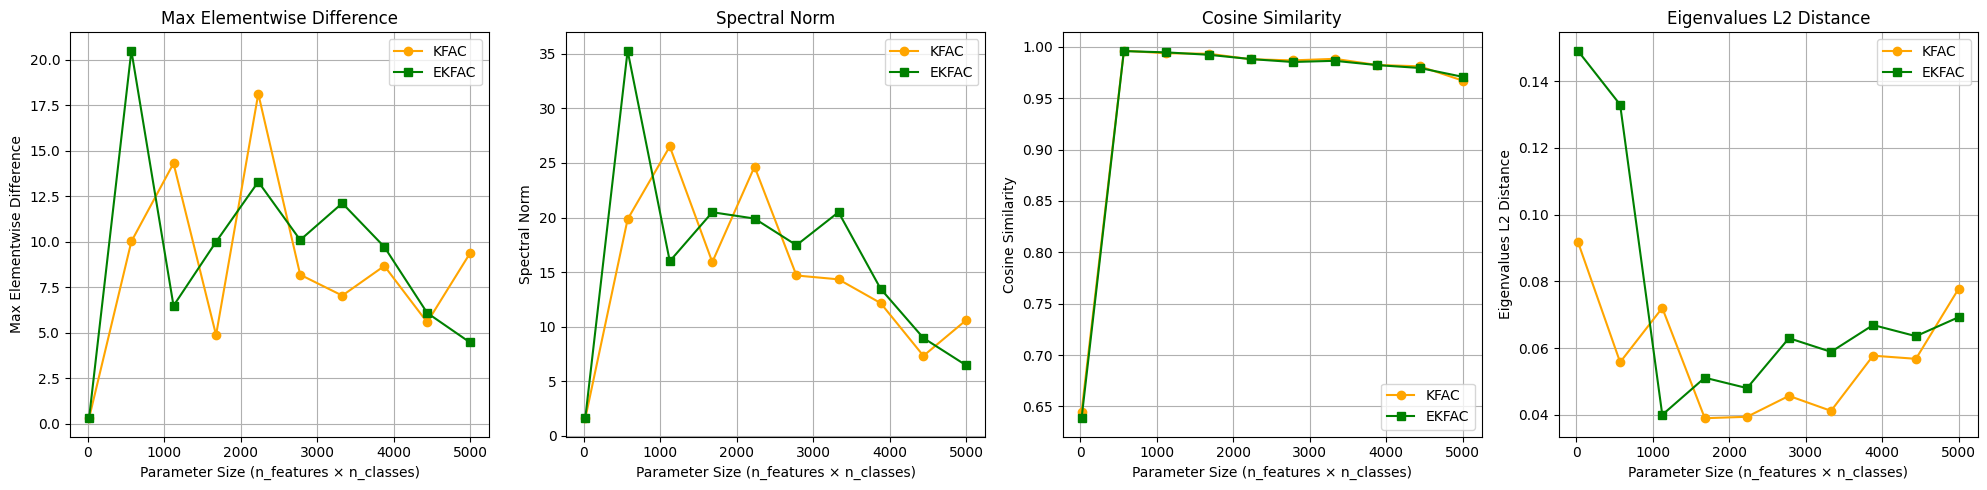

In [135]:
# Extract data for plotting
datasets = list(results_dict.keys())
parameter_sizes = []
max_elementwise_kfac = []
max_elementwise_ekfac = []
spectral_norm_kfac = []
spectral_norm_ekfac = []
cosine_sim_kfac = []
cosine_sim_ekfac = []
eigenval_l2_kfac = []
eigenval_l2_ekfac = []

for dataset in datasets:
    # Extract n_features and n_classes from dataset name
    parts = dataset.split("_")
    n_features = int(parts[3])
    n_classes = int(parts[4])
    param_size = n_features * n_classes
    parameter_sizes.append(param_size)

    # Extract metrics for KFAC and EKFAC
    kfac_metrics = results_dict[dataset]["kfac"]
    ekfac_metrics = results_dict[dataset]["ekfac"]

    max_elementwise_kfac.append(kfac_metrics["max_elementwise"])
    max_elementwise_ekfac.append(ekfac_metrics["max_elementwise"])
    spectral_norm_kfac.append(kfac_metrics["spectral"])
    spectral_norm_ekfac.append(ekfac_metrics["spectral"])
    cosine_sim_kfac.append(kfac_metrics["cosine_similarity"])
    cosine_sim_ekfac.append(ekfac_metrics["cosine_similarity"])
    eigenval_l2_kfac.append(kfac_metrics["eigenvalues_l2_distance"])
    eigenval_l2_ekfac.append(ekfac_metrics["eigenvalues_l2_distance"])

# Create subplot with 4 plots side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot 1: Max Elementwise
axes[0].plot(parameter_sizes, max_elementwise_kfac, "o-", label="KFAC", color="orange")
axes[0].plot(parameter_sizes, max_elementwise_ekfac, "s-", label="EKFAC", color="green")
axes[0].set_xlabel("Parameter Size (n_features × n_classes)")
axes[0].set_ylabel("Max Elementwise Difference")
axes[0].set_title("Max Elementwise Difference")
axes[0].legend()
axes[0].grid(True)

# Plot 2: Spectral Norm
axes[1].plot(parameter_sizes, spectral_norm_kfac, "o-", label="KFAC", color="orange")
axes[1].plot(parameter_sizes, spectral_norm_ekfac, "s-", label="EKFAC", color="green")
axes[1].set_xlabel("Parameter Size (n_features × n_classes)")
axes[1].set_ylabel("Spectral Norm")
axes[1].set_title("Spectral Norm")
axes[1].legend()
axes[1].grid(True)

# Plot 3: Cosine Similarity
axes[2].plot(parameter_sizes, cosine_sim_kfac, "o-", label="KFAC", color="orange")
axes[2].plot(parameter_sizes, cosine_sim_ekfac, "s-", label="EKFAC", color="green")
axes[2].set_xlabel("Parameter Size (n_features × n_classes)")
axes[2].set_ylabel("Cosine Similarity")
axes[2].set_title("Cosine Similarity")
axes[2].legend()
axes[2].grid(True)

# Plot 4: Eigenvalues L2 Distance
axes[3].plot(parameter_sizes, eigenval_l2_kfac, "o-", label="KFAC", color="orange")
axes[3].plot(parameter_sizes, eigenval_l2_ekfac, "s-", label="EKFAC", color="green")
axes[3].set_xlabel("Parameter Size (n_features × n_classes)")
axes[3].set_ylabel("Eigenvalues L2 Distance")
axes[3].set_title("Eigenvalues L2 Distance")
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()


#### Multi-Layer Setup for Random Classification

In [136]:
# --- Multi-Layer Linear Setup (hidden_dim ≠ []) ---
import numpy as np
from typing import Dict
from hessian_approximations.hessian_approximations import HessianApproximation

# 10 balanced target total parameter sizes (≤ 5k)
n_samples = 2000
random_state = 42

target_param_sizes = np.linspace(20, 2000, num=10, dtype=int).tolist()
n_classes_list = [5] * 10  # keep n_classes constant for simplicity


def choose_hidden_dims(target_params: int):
    """
    Choose hidden layer sizes dynamically so that total params ≈ target_params.
    Formula for params: n_features*h1 + h1*h2 + ... + hL*n_classes
    """
    # simple heuristic: one or two hidden layers that fit target budget
    if target_params <= 1000:
        return [10]
    elif target_params <= 3000:
        return [10, 5]
    else:
        return [20, 10, 5]


dataset_nums = []

for target_params, n_classes in zip(target_param_sizes, n_classes_list):
    # derive n_features
    n_features = max(10, int(target_params / n_classes))
    n_informative = min(max(2, int(0.6 * n_features)), 100)

    hidden_dims = choose_hidden_dims(target_params)

    total_params = n_features * hidden_dims[0]
    for i in range(len(hidden_dims) - 1):
        total_params += hidden_dims[i] * hidden_dims[i + 1]
    total_params += hidden_dims[-1] * n_classes

    dataset_nums.append(
        {
            "n_samples": n_samples,
            "n_features": n_features,
            "n_classes": n_classes,
            "n_informative": n_informative,
            "hidden_dims": hidden_dims,
            "total_params": total_params,
        }
    )

dataset_configs = {}
training_configs = {}
total_params_dict = {}

for dataset_num in dataset_nums:
    n_samples = dataset_num["n_samples"]
    n_features = dataset_num["n_features"]
    n_classes = dataset_num["n_classes"]
    n_informative = dataset_num["n_informative"]
    dataset_configs[f"random_classification_{n_samples}_{n_features}_{n_classes}"] = (
        RandomClassificationConfig(
            n_samples=n_samples,
            n_features=n_features,
            n_classes=n_classes,
            n_informative=n_informative,
            random_state=42,
            train_test_split=1,
        )
    )
    training_configs[f"random_classification_{n_samples}_{n_features}_{n_classes}"] = (
        TrainingConfig(
            epochs=100,
            lr=0.001,
            optimizer="sgd",
            batch_size=100,
            loss="cross_entropy",
        )
    )
    total_params_dict[f"random_classification_{n_samples}_{n_features}_{n_classes}"] = (
        dataset_num["total_params"]
    )


# --- Experiment loop ---
results_dict = {}

for dataset_name, dataset_config in dataset_configs.items():
    n_features = dataset_config.n_features
    n_classes = dataset_config.n_classes

    linear_model_config = LinearModelConfig(
        loss="cross_entropy",
        hidden_dim=hidden_dims,
    )

    # Hessian configs to compare
    linear_hessian_configs: Dict[str, HessianApproximation] = {
        "kfac": KFAC(
            config=KFACConfig(
                use_eigenvalue_correction=False,
                use_pseudo_targets=True,
                reload_data=True,
            ),
            model_name="linear_multi_layer",
            dataset_name=dataset_name,
        ),
        "ekfac": KFAC(
            config=KFACConfig(
                use_eigenvalue_correction=True,
                use_pseudo_targets=True,
                reload_data=True,
            ),
            model_name="linear_multi_layer",
            dataset_name=dataset_name,
        ),
    }

    print(f"Processing dataset: {dataset_name} | Hidden dims: {hidden_dims}")
    config = Config(
        dataset=dataset_config,
        model=linear_model_config,
        training=training_configs[dataset_name],
    )

    model, dataset, params = train(config)
    print(f"Comparing Hessians for dataset: {dataset_name}")
    results_dict[dataset_name] = compare_approximation_with_true_hessian(
        model=model,
        params=params,
        dataset=dataset,
        hessian_configs_approx=linear_hessian_configs,
        hessian_config_gt=Hessian(),
    )
    print(f"Completed dataset: {dataset_name}")


Processing dataset: random_classification_2000_10_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 67.89it/s]


Comparing Hessians for dataset: random_classification_2000_10_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_10_5
Processing dataset: random_classification_2000_48_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 63.14it/s]


Comparing Hessians for dataset: random_classification_2000_48_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_48_5
Processing dataset: random_classification_2000_92_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 62.64it/s]


Comparing Hessians for dataset: random_classification_2000_92_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_92_5
Processing dataset: random_classification_2000_136_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 62.25it/s]


Comparing Hessians for dataset: random_classification_2000_136_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_136_5
Processing dataset: random_classification_2000_180_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 62.47it/s]


Comparing Hessians for dataset: random_classification_2000_180_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_180_5
Processing dataset: random_classification_2000_224_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 60.31it/s]


Comparing Hessians for dataset: random_classification_2000_224_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_224_5
Processing dataset: random_classification_2000_268_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 58.38it/s]


Comparing Hessians for dataset: random_classification_2000_268_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_268_5
Processing dataset: random_classification_2000_312_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 56.54it/s]


Comparing Hessians for dataset: random_classification_2000_312_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_312_5
Processing dataset: random_classification_2000_356_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 57.38it/s]


Comparing Hessians for dataset: random_classification_2000_356_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_356_5
Processing dataset: random_classification_2000_400_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 57.39it/s]


Comparing Hessians for dataset: random_classification_2000_400_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_400_5


In [137]:
# Print the final results as before

print("Final Results for Multi-Layer Linear Models:")
for dataset_name, result in results_dict.items():
    print(f"Dataset: {dataset_name}")
    for approx_name, metrics in result.items():
        print(f"  Approximation: {approx_name}")
        for metric_name, value in metrics.items():
            print(f"    {metric_name}: {value}")

Final Results for Multi-Layer Linear Models:
Dataset: random_classification_2000_10_5
  Approximation: kfac
    relative_frobenius: 0.7723162174224854
    max_elementwise: 0.3700261116027832
    spectral: 2.360881805419922
    spectral_relative: 0.5958412289619446
    cosine_similarity: 0.6458891034126282
    eigenvalue_max: 1.5659759044647217
    eigenvalues_l2_distance: 0.3745008707046509
    trace_distance: 0.022819551740373884
    condition_number_log_ratio: 1.3192501068115234
  Approximation: ekfac
    relative_frobenius: 0.7599413394927979
    max_elementwise: 0.3700261116027832
    spectral: 2.6008822917938232
    spectral_relative: 0.6564127206802368
    cosine_similarity: 0.6499994397163391
    eigenvalue_max: 2.057494640350342
    eigenvalues_l2_distance: 0.45670202374458313
    trace_distance: 0.0015539332798549107
    condition_number_log_ratio: 0.9280452728271484
Dataset: random_classification_2000_48_5
  Approximation: kfac
    relative_frobenius: 0.6038357615470886
    m

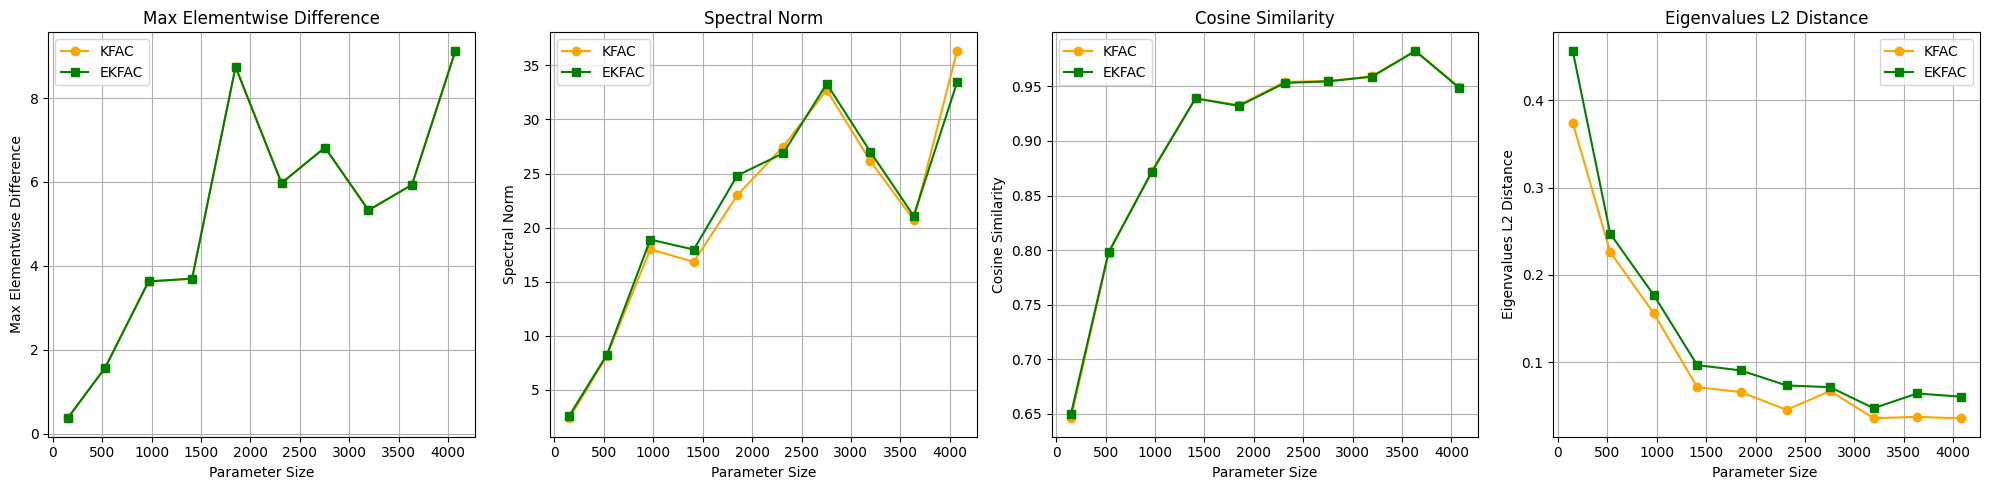

In [138]:
# Plot results

# Extract data for plotting
datasets = list(results_dict.keys())
parameter_sizes = []
max_elementwise_kfac = []
max_elementwise_ekfac = []
spectral_norm_kfac = []
spectral_norm_ekfac = []
cosine_sim_kfac = []
cosine_sim_ekfac = []
eigenval_l2_kfac = []
eigenval_l2_ekfac = []

for dataset in datasets:
    # Extract n_features and n_classes from dataset name
    parts = dataset.split("_")
    n_features = int(parts[3])
    n_classes = int(parts[4])
    param_size = total_params_dict[
        f"random_classification_{n_samples}_{n_features}_{n_classes}"
    ]
    parameter_sizes.append(param_size)

    # Extract metrics for KFAC and EKFAC
    kfac_metrics = results_dict[dataset]["kfac"]
    ekfac_metrics = results_dict[dataset]["ekfac"]

    max_elementwise_kfac.append(kfac_metrics["max_elementwise"])
    max_elementwise_ekfac.append(ekfac_metrics["max_elementwise"])
    spectral_norm_kfac.append(kfac_metrics["spectral"])
    spectral_norm_ekfac.append(ekfac_metrics["spectral"])
    cosine_sim_kfac.append(kfac_metrics["cosine_similarity"])
    cosine_sim_ekfac.append(ekfac_metrics["cosine_similarity"])
    eigenval_l2_kfac.append(kfac_metrics["eigenvalues_l2_distance"])
    eigenval_l2_ekfac.append(ekfac_metrics["eigenvalues_l2_distance"])

# Create subplot with 4 plots side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot 1: Max Elementwise
axes[0].plot(parameter_sizes, max_elementwise_kfac, "o-", label="KFAC", color="orange")
axes[0].plot(parameter_sizes, max_elementwise_ekfac, "s-", label="EKFAC", color="green")
axes[0].set_xlabel("Parameter Size")
axes[0].set_ylabel("Max Elementwise Difference")
axes[0].set_title("Max Elementwise Difference")
axes[0].legend()
axes[0].grid(True)

# Plot 2: Spectral Norm
axes[1].plot(parameter_sizes, spectral_norm_kfac, "o-", label="KFAC", color="orange")
axes[1].plot(parameter_sizes, spectral_norm_ekfac, "s-", label="EKFAC", color="green")
axes[1].set_xlabel("Parameter Size")
axes[1].set_ylabel("Spectral Norm")
axes[1].set_title("Spectral Norm")
axes[1].legend()
axes[1].grid(True)

# Plot 3: Cosine Similarity
axes[2].plot(parameter_sizes, cosine_sim_kfac, "o-", label="KFAC", color="orange")
axes[2].plot(parameter_sizes, cosine_sim_ekfac, "s-", label="EKFAC", color="green")
axes[2].set_xlabel("Parameter Size")
axes[2].set_ylabel("Cosine Similarity")
axes[2].set_title("Cosine Similarity")
axes[2].legend()
axes[2].grid(True)

# Plot 4: Eigenvalues L2 Distance
axes[3].plot(parameter_sizes, eigenval_l2_kfac, "o-", label="KFAC", color="orange")
axes[3].plot(parameter_sizes, eigenval_l2_ekfac, "s-", label="EKFAC", color="green")
axes[3].set_xlabel("Parameter Size ")
axes[3].set_ylabel("Eigenvalues L2 Distance")
axes[3].set_title("Eigenvalues L2 Distance")
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()


#### MLP Setup



In [ ]:
# --- Multi-Layer MLP Setup (hidden_dim ≠ [])---
import numpy as np
from typing import Dict
from hessian_approximations.hessian_approximations import HessianApproximation

# 10 balanced target total parameter sizes (≤ 5k)
n_samples = 2000
random_state = 42

target_param_sizes = np.linspace(20, 2000, num=10, dtype=int).tolist()
n_classes_list = [5] * 10  # keep n_classes constant for simplicity


def choose_hidden_dims(target_params: int):
    """
    Choose hidden layer sizes dynamically so that total params ≈ target_params.
    Formula for params: n_features*h1 + h1*h2 + ... + hL*n_classes
    """
    # simple heuristic: one or two hidden layers that fit target budget
    if target_params <= 1000:
        return [10]
    elif target_params <= 3000:
        return [10, 5]
    else:
        return [20, 10, 5]


dataset_nums = []

for target_params, n_classes in zip(target_param_sizes, n_classes_list):
    # derive n_features
    n_features = max(10, int(target_params / n_classes))
    n_informative = min(max(2, int(0.6 * n_features)), 100)

    hidden_dims = choose_hidden_dims(target_params)

    total_params = n_features * hidden_dims[0]
    for i in range(len(hidden_dims) - 1):
        total_params += hidden_dims[i] * hidden_dims[i + 1]
    total_params += hidden_dims[-1] * n_classes

    dataset_nums.append(
        {
            "n_samples": n_samples,
            "n_features": n_features,
            "n_classes": n_classes,
            "n_informative": n_informative,
            "hidden_dims": hidden_dims,
            "total_params": total_params,
        }
    )

dataset_configs = {}
training_configs = {}
total_params_dict = {}

for dataset_num in dataset_nums:
    n_samples = dataset_num["n_samples"]
    n_features = dataset_num["n_features"]
    n_classes = dataset_num["n_classes"]
    n_informative = dataset_num["n_informative"]
    dataset_configs[f"random_classification_{n_samples}_{n_features}_{n_classes}"] = (
        RandomClassificationConfig(
            n_samples=n_samples,
            n_features=n_features,
            n_classes=n_classes,
            n_informative=n_informative,
            random_state=42,
            train_test_split=1,
        )
    )
    training_configs[f"random_classification_{n_samples}_{n_features}_{n_classes}"] = (
        TrainingConfig(
            epochs=100,
            lr=0.001,
            optimizer="sgd",
            batch_size=100,
            loss="cross_entropy",
        )
    )
    total_params_dict[f"random_classification_{n_samples}_{n_features}_{n_classes}"] = (
        dataset_num["total_params"]
    )


# --- Experiment loop ---
results_dict = {}

for dataset_name, dataset_config in dataset_configs.items():
    n_features = dataset_config.n_features
    n_classes = dataset_config.n_classes

    mlp_model_config = MLPModelConfig(
        loss="cross_entropy",
        hidden_dim=hidden_dims,
        use_bias=False,
    )

    # Hessian configs to compare
    mlp_hessian_configs: Dict[str, HessianApproximation] = {
        "kfac": KFAC(
            config=KFACConfig(
                use_eigenvalue_correction=False,
                use_pseudo_targets=True,
                reload_data=True,
            ),
            model_name="mlp_multi_layer",
            dataset_name=dataset_name,
        ),
        "ekfac": KFAC(
            config=KFACConfig(
                use_eigenvalue_correction=True,
                use_pseudo_targets=True,
                reload_data=True,
            ),
            model_name="mlp_multi_layer",
            dataset_name=dataset_name,
        ),
    }

    print(f"Processing dataset: {dataset_name} | Hidden dims: {hidden_dims}")
    config = Config(
        dataset=dataset_config,
        model=mlp_model_config,
        training=training_configs[dataset_name],
    )

    model, dataset, params = train(config)
    print(f"Comparing Hessians for dataset: {dataset_name}")
    results_dict[dataset_name] = compare_approximation_with_true_hessian(
        model=model,
        params=params,
        dataset=dataset,
        hessian_configs_approx=mlp_hessian_configs,
        hessian_config_gt=Hessian(),
    )
    print(f"Completed dataset: {dataset_name}")


Processing dataset: random_classification_2000_10_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 63.04it/s]


Comparing Hessians for dataset: random_classification_2000_10_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_10_5
Processing dataset: random_classification_2000_48_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 66.97it/s]


Comparing Hessians for dataset: random_classification_2000_48_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_48_5
Processing dataset: random_classification_2000_92_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 67.47it/s]


Comparing Hessians for dataset: random_classification_2000_92_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_92_5
Processing dataset: random_classification_2000_136_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 65.82it/s]


Comparing Hessians for dataset: random_classification_2000_136_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_136_5
Processing dataset: random_classification_2000_180_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 65.80it/s]


Comparing Hessians for dataset: random_classification_2000_180_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_180_5
Processing dataset: random_classification_2000_224_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 64.05it/s]


Comparing Hessians for dataset: random_classification_2000_224_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_224_5
Processing dataset: random_classification_2000_268_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 57.39it/s]


Comparing Hessians for dataset: random_classification_2000_268_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_268_5
Processing dataset: random_classification_2000_312_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 56.48it/s]


Comparing Hessians for dataset: random_classification_2000_312_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_312_5
Processing dataset: random_classification_2000_356_5 | Hidden dims: [10, 5]


100%|██████████| 100/100 [00:01<00:00, 56.46it/s]


Comparing Hessians for dataset: random_classification_2000_356_5
Computing true Hessian...
Comparing approximations...
Computing kfac...
Computing EKFAC components from scratch.
Computing ekfac...
Computing EKFAC components from scratch.
Completed dataset: random_classification_2000_356_5
Processing dataset: random_classification_2000_400_5 | Hidden dims: [10, 5]


 57%|█████▋    | 57/100 [00:01<00:00, 62.45it/s]

In [ ]:
# Print results
print("Final Results for Multi-Layer MLP Models:")
for dataset_name, result in results_dict.items():
    print(f"Dataset: {dataset_name}")
    for approx_name, metrics in result.items():
        print(f"  Approximation: {approx_name}")
        for metric_name, value in metrics.items():
            print(f"    {metric_name}: {value}")

# Plot results
# Extract data for plotting
datasets = list(results_dict.keys())
parameter_sizes = []
max_elementwise_kfac = []
max_elementwise_ekfac = []
spectral_norm_kfac = []
spectral_norm_ekfac = []
cosine_sim_kfac = []
cosine_sim_ekfac = []
eigenval_l2_kfac = []
eigenval_l2_ekfac = []

for dataset in datasets:
    # Extract n_features and n_classes from dataset name
    parts = dataset.split("_")
    n_features = int(parts[3])
    n_classes = int(parts[4])
    param_size = total_params_dict[
        f"random_classification_{n_samples}_{n_features}_{n_classes}"
    ]
    parameter_sizes.append(param_size)

    # Extract metrics for KFAC and EKFAC
    kfac_metrics = results_dict[dataset]["kfac"]
    ekfac_metrics = results_dict[dataset]["ekfac"]

    max_elementwise_kfac.append(kfac_metrics["max_elementwise"])
    max_elementwise_ekfac.append(ekfac_metrics["max_elementwise"])
    spectral_norm_kfac.append(kfac_metrics["spectral"])
    spectral_norm_ekfac.append(ekfac_metrics["spectral"])
    cosine_sim_kfac.append(kfac_metrics["cosine_similarity"])
    cosine_sim_ekfac.append(ekfac_metrics["cosine_similarity"])
    eigenval_l2_kfac.append(kfac_metrics["eigenvalues_l2_distance"])
    eigenval_l2_ekfac.append(ekfac_metrics["eigenvalues_l2_distance"])